<a href="https://colab.research.google.com/github/doug14226/colab1/blob/master/Photo_SlicerTiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Demonstration of Python for Photo Processing
Copyright (c) 2018 Douglas Lange.  
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

##Block 1: Setup Python environment


---
Get Mona_Lisa.jpg and install Cairo package.
Execution of this block will produce a setup.log file.
If faults occur, please download setup.log and post new issue with setup.log as attachment at https://github.com/doug14226/colab1/issues. To download setup.log run the following in a new  cell.  (to add cell press +code above)

---
from google.colab import files  
files.download("setup.log")



In [0]:
def dougpawsPhotoTilesSetup():

    def install_not_needed():
        lsout = !ls -l Mona_Lisa.jpg
        if len(lsout[0].split()) > 4 and (lsout[0].split()[4] == '401542'):
            try:
                import cairo    
                return(True)
            except ImportError:
                pass
        return(False)

    if install_not_needed():
        return

    log = open("setup.log","a")

    def printlog(cmdout,log):
        for line in cmdout:
            print(line, file = log)

    print("\nSetup required ", file = log)

# log date time stamp
    from datetime import datetime
    print(datetime.utcnow(), file = log)

# log python version
    import sys
    print("Log Python Version", file = log)
    print(sys.version, file=log)


# log OS version
    cmdout = !uname -a
    print("ID OS version", file = log)
    printlog(cmdout, log)
    cmdout = !cat /proc/cpuinfo
    printlog(cmdout, log)
    cmdout = !cat /proc/meminfo
    printlog(cmdout, log)

#download  Mona_Lisa.jpg from google drive
# by using a shared link account name & password are not needed
#shared link = https://drive.google.com/file/d/1_hUkSmQjXfxMwq170pOlRxdgf7hajgHd/view?usp=sharing
    lsout = !ls -l Mona_Lisa.jpg
    if (lsout[0].split()[4] != '401542'):
        fileID = "1_hUkSmQjXfxMwq170pOlRxdgf7hajgHd"
        cmdout =!wget -O Mona_Lisa.jpg "https://drive.google.com/uc?export=download&id=1_hUkSmQjXfxMwq170pOlRxdgf7hajgHd"
        print("installing Mona_Lisa.jpg",file = log )
        printlog(cmdout, log)

#if cairo not installed install it
    try:
       import cairo
    except ImportError:
        print("installing Mona_Lisa.jpg",file = log )
        cmdout = !apt-get install libcairo2-dev
        printlog(cmdout, log)
        cmdout = !pip3 install pycairo
        printlog(cmdout, log)

#check if all requirementss were installed

    if install_not_needed():
        print("Install finished without errors")
    else:
        print("Insstall failed, check setup.log")
 
dougpawsPhotoTilesSetup()

##Block 2: Define *tileIm* and *sliceIm* functions


In [0]:
def tileIm(image, rects, n):
  if n==2:
    return sliceIm(image, rects, 2)
  minmax = max(image.shape)
  nxtrects = []
  for rect in rects:
    top = rect[0]
    bottom = rect[1]
    left = rect[2]
    right = rect[3]
    im = image[top:bottom,left:right]
    rowsum = im.sum(axis=1)
    colsum = im.sum(axis=0)
    if (bottom - top) > (right - left):
      cumrowsum = rowsum.cumsum()
      xr = np.amin(cumrowsum)
      mr = (np.amax(cumrowsum)-xr)/n
      t1 = 0
      b1 = np.amin(np.nonzero(cumrowsum>=(xr+mr)))
      t2 = np.amin(np.nonzero(cumrowsum>=(xr+(mr*(n-1)))))
      b2 = bottom-top
      if ((b1 - t1) > (b2 - t2)):
        rrects = tileIm(image, [[top + b1, bottom, left, right ]], n - 1)
        nxtrects.append( [top, top + b1, left, right] )
      else:
        rrects = tileIm(image, [[top , top + t2, left, right ]], n - 1)
        nxtrects.append( [top + t2, bottom, left, right] )
      for rrrect in rrects:
        nxtrects.append(rrrect)
    else:
      cumcolsum = colsum.cumsum()
      xc = np.amin(cumcolsum)             
      mc = (np.amax(cumcolsum)-xc)/n
      l1 = 0
      r1 = np.amin(np.nonzero(cumcolsum>=(xc+mc)))
      l2 = np.amin(np.nonzero(cumcolsum>=(xc+(mc*(n-1)))))
      r2 = right - left
      if ((r1 - l1) > (r2 -l2)):
        rrects = tileIm(image, [[top , bottom, left + r1, right ]], n -1 )
        nxtrects.append( [top, bottom, left, left + r1] )
      else:
        rrects = tileIm(image, [[top , bottom, left, left+l2]], n - 1)
        nxtrects.append( [top, bottom, left +l2, right] )
      for rrrect in rrects:
        nxtrects.append(rrrect)
  return nxtrects
  
def sliceIm(image, rects, n):
  nxtrects = []
  for rect in rects:
    top = rect[0]
    bottom = rect[1]
    left = rect[2]
    right = rect[3]
    im = image[top:bottom,left:right]      
    if (bottom - top) > (right - left):
      rowsum = im.sum(axis=1)
      cumrowsum = rowsum.cumsum()
      xr = np.amin(cumrowsum)
      mr = (np.amax(cumrowsum)-xr)/n
      for i in range(1,n):
        t = np.amin(np.nonzero(cumrowsum>=(xr+(mr*(i-1)))))
        b = np.amin(np.nonzero(cumrowsum>=(xr+(mr*i))))
        nxtrects.append( [top + t, top + b, left, right] )
      nxtrects.append( [top + b, bottom , left, right] )
    else:
      colsum = im.sum(axis=0)
      cumcolsum = colsum.cumsum()
      xc = np.amin(cumcolsum)             
      mc = (np.amax(cumcolsum)-xc)/n
      for i in range(1, n):
        r = np.amin(np.nonzero(cumcolsum>=(xc+(mc*(i-1)))))
        l = np.amin(np.nonzero(cumcolsum>=(xc+(mc*i))))
        nxtrects.append( [top, bottom, left + r, left + l] )
      nxtrects.append( [top, bottom, left + l, right] )
  return nxtrects

##Block 3: Define *drawImage* and *displayImage* functions

In [0]:
def drawImage(slice, hue, fileOut):

  def drawRectangles(slice, ctx):
    for rect in slice: 
        top = rect[0]
        bottom = rect[1]
        left = rect[2]
        right = rect[3]
        ctx.rectangle(left, top, right-left, bottom-top)
        ctx.stroke()
        
  surface = cairo.SVGSurface(fileOut, im.shape[1], im.shape[0])
  ctx = cairo.Context(surface)
  ctx.rectangle(0, 0,  im.shape[1], im.shape[0])
  ctx.set_source_rgb(*hue)
  ctx.fill()
  ctx.set_source_rgb(0, 0, 0)
  ctx.set_line_width(1)
  drawRectangles(slice, ctx)
  return(surface)

def displayImage(surface):    
  bytes = BytesIO()
  surface.write_to_png(bytes)
  bytes.seek(0)
  binarydata = bytes.read()
  i = display.Image(data = binarydata)
  display.display(i)


##Block 4:  The main program

---
Import required Python Packages   
open Mona_Lisa.jpg  
convert to Black and white  
invert for photo negative  

In [0]:
import numpy as np
import cairo
from PIL import Image
from io import BytesIO
from IPython.core import display
from google.colab import files 
pic = Image.open("Mona_Lisa.jpg")
picbw = pic.convert('L')
temp = (np.array(pic)/255)
im = 1.0 -temp[:,:,0]

divisor =  5
divisor =  5


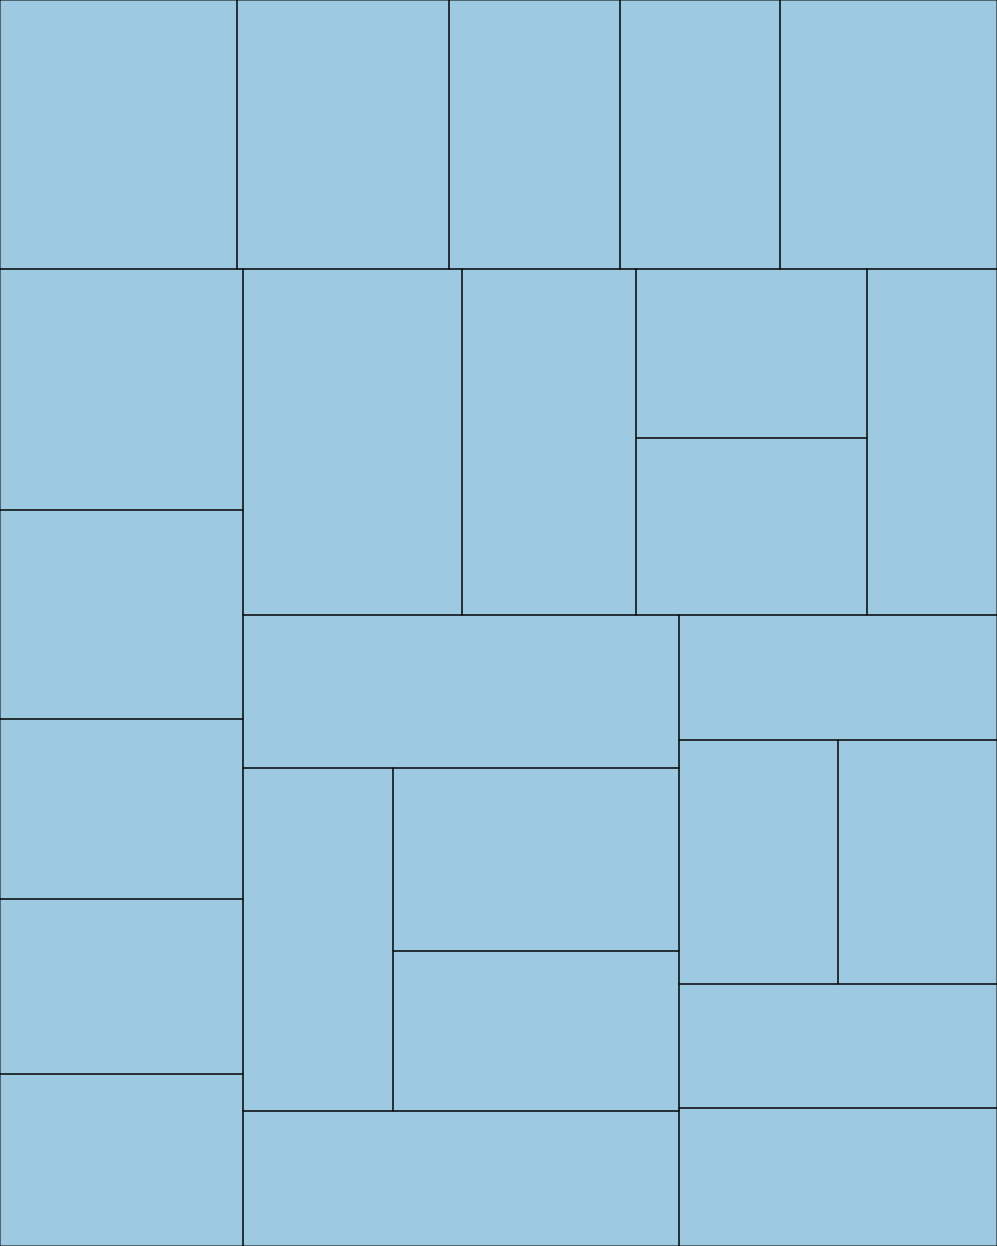

In [25]:
#@title Tile or Slice the image
Tile = True #@param {type:"boolean"}
Divisors = [5,5,5,5,3,3,2,2] #@param {type:"raw"}
background_hue = (.62,.79,.88) #@param {type:"raw"}
fileOut = "Mona_Lisa.svg" #@param {type:"string"}
def main():
  slice =  [[0, im.shape[0], 0, im.shape[1]]]
  for n in Divisors:
    try:
      if Tile:
        slice = tileIm(im, slice, n)
      else:
        slice = sliceIm(im, slice, n)
      print("divisor = ", n)
    except:
      break
  surface = drawImage(slice, background_hue, fileOut )
  displayImage(surface)
  
main()

In [0]:
#@title Download SVG file? { run: "auto" }
download = False #@param {type:"boolean"}
if download: 
  files.download(fileOut)
  